In [ ]:
!pip install numpy==1.24.4
!pip install roboflow
!pip install pycocotools

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="d9rgyowU5KPlOKliPoM2")
project = rf.workspace("ivonne").project("drones-oddbp")
version = project.version(3)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...


In [ ]:
import os
import shutil

# Görselleri /train/images/ alt klasörüne taşı
os.makedirs("/content/Drones-3/train/images", exist_ok=True)

# /train klasöründeki tüm .jpg dosyalarını /train/images klasörüne taşı
for filename in os.listdir("/content/Drones-3/train"):
    if filename.endswith(".jpg"):
        shutil.move(
            f"/content/Drones-3/train/{filename}",
            f"/content/Drones-3/train/images/{filename}"
        )


In [ ]:
# Anotasyon dosyasını kontrol et
annotation_path = "/content/Drones-3/train/_annotations.coco.json"

if os.path.exists(annotation_path):
    print("✅ Anotasyon dosyası bulundu:", annotation_path)
else:
    print("❌ Anotasyon dosyası eksik! Roboflow indirirken 'COCO JSON' formatını seçip tekrar indir.")


✅ Anotasyon dosyası bulundu: /content/Drones-3/train/_annotations.coco.json


In [ ]:
from pycocotools.coco import COCO
from torch.utils.data import Dataset
from PIL import Image
import torch
import os

class COCODataset(Dataset):
    def __init__(self, image_dir, annotation_file, transforms=None):
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())  # Önemli: __len__ burada bu listeyi kullanıyor
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, idx):
        while True:
            image_id = self.image_ids[idx]
            image_info = self.coco.loadImgs(image_id)[0]
            img_path = os.path.join(self.image_dir, image_info['file_name'])
            img = Image.open(img_path).convert("RGB")

            ann_ids = self.coco.getAnnIds(imgIds=image_id)
            anns = self.coco.loadAnns(ann_ids)

            if len(anns) == 0:
                # anotasyon yoksa başka bir örnek seç
                idx = (idx + 1) % len(self.image_ids)
                continue

            boxes = []
            labels = []
            for ann in anns:
                xmin, ymin, width, height = ann['bbox']
                boxes.append([xmin, ymin, xmin + width, ymin + height])
                labels.append(ann['category_id'])

            target = {
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64),
                "image_id": torch.tensor([image_id])
            }

            if self.transforms:
                img = self.transforms(img)

            return img, target


    def __len__(self):
        return len(self.image_ids)


In [ ]:
train_dataset = COCODataset(
    image_dir="/content/Drones-3/train/images",
    annotation_file="/content/Drones-3/train/_annotations.coco.json",
    transforms=F.to_tensor
)

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))
)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = fasterrcnn_resnet50_fpn(pretrained=True)

# COCO'dan alınan sınıf sayısı (senin verisindeki sınıf sayısı + 1 background)
num_classes = len(train_dataset.coco.getCatIds()) + 1

# Yeni predictor ile değiştir
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

for epoch in range(5):
    model.train()
    total_loss = 0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")


Epoch 1 - Loss: 184.9064
Epoch 2 - Loss: 121.3332
Epoch 3 - Loss: 101.4136
Epoch 4 - Loss: 90.8077
Epoch 5 - Loss: 85.1280


In [ ]:
torch.save(model.state_dict(), "fasterrcnn_model_coco.pth")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Sonra kaydet:
torch.save(model.state_dict(), "/content/drive/MyDrive/fasterrcnn_model_coco.pth")

Mounted at /content/drive


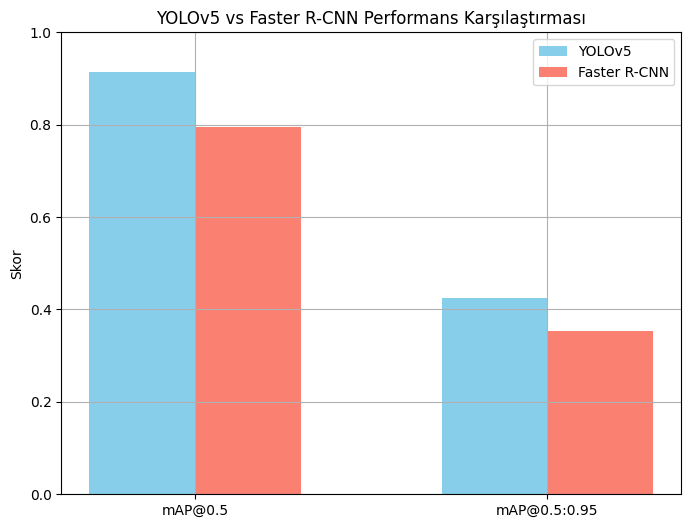

In [ ]:
import matplotlib.pyplot as plt

# Veriler
labels = ["mAP@0.5", "mAP@0.5:0.95"]
yolo_scores = [0.914, 0.425]
faster_scores = [0.796, 0.354]

x = range(len(labels))

# Grafik çizimi
plt.figure(figsize=(8, 6))
plt.bar([i - 0.15 for i in x], yolo_scores, width=0.3, label="YOLOv5", color='skyblue')
plt.bar([i + 0.15 for i in x], faster_scores, width=0.3, label="Faster R-CNN", color='salmon')

plt.xticks(x, labels)
plt.ylabel("Skor")
plt.title("YOLOv5 vs Faster R-CNN Performans Karşılaştırması")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()
